<a href="https://colab.research.google.com/github/reyllama/TTIO/blob/master/04_Rescaling_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
path = "/content/drive/My Drive/corr3.csv"
df = pd.read_csv(path)
df = df.set_index(keys='stock_id')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,000120,000140,000145,000150,000155,000157,000180,000210,000215,000220,000225,000227,000230,000240,000250,000270,000300,000320,000325,000370,000390,000400,000430,000440,000480,000490,000500,000520,000540,000545,...,95190,95270,95340,95500,95570,95610,95660,95700,95720,95910,96040,96240,96300,96350,96530,96610,96630,96640,96760,96770,96775,96870,97230,97520,97780,97800,97870,97950,97955,98120,98460,98660,99190,99220,99320,99340,99350,99410,99440,99520
stock_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000020,1.000000,0.225326,0.190993,0.091289,0.278384,0.106534,0.099041,0.118218,0.412659,0.149035,0.206372,0.345200,0.239751,0.306873,0.139372,0.083818,0.432648,0.320367,0.314789,0.477852,0.390176,0.346164,0.213423,0.009110,0.410569,0.105879,0.404843,0.133121,0.297274,0.332258,0.313026,0.379187,0.141835,0.161505,0.030559,0.196879,0.188596,0.499444,-0.028242,-0.026712,...,0.209581,0.232547,0.223981,0.328538,0.087554,0.116857,0.409012,0.511532,0.203512,0.285751,0.129244,0.153266,0.126188,0.305188,0.455201,0.086679,0.397978,0.274513,0.518429,0.076621,0.031647,0.166450,0.253614,0.197545,0.058612,0.349249,0.347917,0.187737,0.226750,0.126712,0.085994,0.004352,0.375279,0.250622,0.217417,0.139307,0.094990,0.378860,0.353696,0.209319
000040,0.225326,1.000000,0.094916,-0.004544,0.059474,0.060820,0.124682,0.056387,0.209455,0.054128,-0.075235,0.119661,0.236891,-0.060359,-0.035623,-0.035829,0.317652,0.176512,0.020059,0.328834,0.247685,0.211691,0.115099,-0.014752,0.139633,-0.096755,0.314768,0.189131,0.358526,-0.004887,0.193405,0.059967,0.100306,0.149209,0.122399,0.201767,0.035985,0.317873,-0.162010,-0.180628,...,0.016408,0.144741,0.088078,0.200713,0.163985,0.314903,0.265392,0.203224,0.180150,0.190553,0.126491,0.150775,0.060059,0.246017,0.192996,0.088002,0.305419,0.062956,0.216271,0.089516,0.072886,0.211917,0.113564,0.218824,0.149922,0.178068,0.321512,0.088847,0.075557,0.054879,0.014856,0.178596,0.206972,0.239557,0.201670,0.112794,0.182726,0.236256,0.229121,0.138442
000050,0.190993,0.094916,1.000000,-0.083876,0.053535,0.275152,-0.268272,-0.078420,0.606344,0.287126,0.116990,-0.094776,-0.187100,0.077364,0.044405,0.031376,0.086244,0.099625,0.065717,0.143305,-0.029988,-0.000439,0.136625,0.036080,0.074330,0.096108,0.037376,-0.057867,-0.014226,-0.187444,0.013196,0.028301,0.104206,-0.081945,-0.027956,0.079866,0.053133,0.010611,-0.010329,0.026074,...,0.135364,-0.037521,0.082185,0.108906,0.072816,0.078859,0.056908,0.129180,-0.035751,0.013647,0.154071,-0.002654,0.084687,0.167558,0.256896,0.053647,0.098211,0.046830,0.451140,0.012075,-0.201710,-0.140452,0.082391,0.032930,0.079592,0.176558,0.064341,0.067198,0.133828,0.052540,0.082745,0.061835,0.090441,-0.011121,0.127440,-0.062998,-0.092143,0.034857,0.005743,0.041519
000060,0.091289,-0.004544,-0.083876,1.000000,0.123051,-0.029442,0.098188,0.163410,0.002685,0.071211,-0.043771,-0.051418,0.129886,0.203375,0.195282,0.178852,0.050663,0.066275,0.109603,-0.094076,-0.045850,0.051034,0.121892,0.056922,-0.004314,0.090554,0.166817,0.076133,0.061512,0.173798,0.181533,0.223820,-0.088203,0.060220,0.022132,0.076012,0.134598,0.146300,-0.086350,-0.084896,...,-0.026554,0.061883,0.024242,0.119134,-0.119198,0.044423,0.093497,0.095074,0.239250,0.063026,0.053660,-0.017570,0.022427,0.145879,0.009135,0.019071,0.059579,-0.004432,-0.074869,0.135409,0.117887,0.165979,0.108465,0.102076,-0.015843,0.125635,0.013862,0.142093,0.147167,0.080525,0.143968,-0.053646,0.110692,-0.067616,-0.014384,0.021044,0.051751,-0.029011,0.158526,-0.000352
000070,0.278384,0.059474,0.053535,0.123051,1.000000,0.130724,0.179808,0.259878,0.191164,0.066421,0.237759,0.138221,0.178195,0.072153,0.176960,0.036070,0.226709,0.106451,-0.011214,0.206232,0.106381,0.144500,0.209959,0.026213,0.118763,0.014829,0.098732,0.195508,0.053784,0.183455,0.229235,-0.043288,0.096291,0.068382,0.137581,0.039107,0.109441,0.221605,0.010337,0.026602,...,0.107730,-0.008949,0.089749,0.200

In [ ]:
dtype = torch.FloatTensor
epochs = 100
emb_dim = 32
embeddings = Variable(torch.randn(emb_dim, len(df)).type(dtype), requires_grad=True)
lr = 0.01
optimizer = optim.Adam([embeddings], lr=lr)
mean = np.abs(df).mean().mean()
coef = 1/mean
loss_track = []

for epoch in range(epochs):
  loss = 0
  for i in range(len(df)):
    v1 = embeddings[:, i].view(emb_dim, -1)
    dist = torch.norm(v1 - embeddings, dim=0).view(len(df), 1)
    corrs = torch.from_numpy(np.abs(coef*np.array(df.iloc[:, i]))-1).view(1, len(df)).type(torch.FloatTensor)
    loss += torch.mm(corrs, dist)/2
  loss_track.append(loss.item())
  if (epoch+1) % 5 == 0:
    print("{0}th epoch in process".format(epoch+1))
    print('running loss: {}'.format(loss.item()))
    print()

  optimizer.zero_grad()
  loss.backward(retain_graph=False)
  optimizer.step()

  with torch.no_grad():
    for element in embeddings:
      element.clamp_(0,1)

embeddings[:, 1]  

5th epoch in process
running loss: -97831.3671875

10th epoch in process
running loss: -218682.34375

15th epoch in process
running loss: -340606.78125

20th epoch in process
running loss: -463022.84375

25th epoch in process
running loss: -585659.0

30th epoch in process
running loss: -708346.1875

35th epoch in process
running loss: -830881.75

40th epoch in process
running loss: -952611.25

45th epoch in process
running loss: -1070280.875

50th epoch in process
running loss: -1168618.625

55th epoch in process
running loss: -1181287.25

60th epoch in process
running loss: -1185593.125

65th epoch in process
running loss: -1209998.5

70th epoch in process
running loss: -1225115.5

75th epoch in process
running loss: -1227955.125

80th epoch in process
running loss: -1238704.25

85th epoch in process
running loss: -1242066.625

90th epoch in process
running loss: -1246125.125

95th epoch in process
running loss: -1250521.625

100th epoch in process
running loss: -1254425.875



tensor([0.5711, 0.5357, 0.5078, 0.4733, 0.5553, 0.5402, 0.5506, 0.4912, 0.5515,
        0.5293, 0.4965, 0.5365, 0.5250, 0.5272, 0.5324, 0.5115, 0.5403, 0.5241,
        0.5117, 0.5242, 0.5466, 0.4941, 0.4811, 0.5217, 0.5078, 0.5238, 0.5280,
        0.5249, 0.5247, 0.5197, 0.5329, 0.5382], grad_fn=<SelectBackward>)

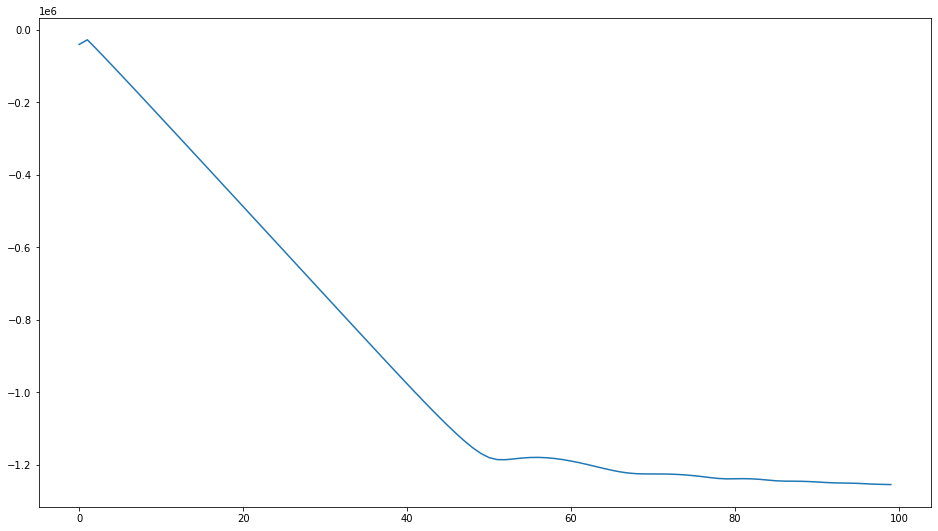

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(list(range(epochs)), loss_track)
plt.show()

In [ ]:
embeddings

tensor([[0.5709, 0.5711, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.5379, 0.5357, 0.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.5088, 0.5078, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.5198, 0.5197, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.5329, 0.5329, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5397, 0.5382, 0.0000,  ..., 0.0000, 1.0000, 0.0000]],
       requires_grad=True)

## Rescaling Network

In [23]:
data = pd.read_csv("/content/drive/My Drive/stocks.csv")
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,stock_id,name,date,opening_price,highest_price,lowest_price,closing_price,trading_volume
0,000020,동화약품,2016-01-04,8130,8150,7920,8140,281440
1,000020,동화약품,2016-01-05,8040,8250,8000,8190,243179
2,000020,동화약품,2016-01-06,8200,8590,8110,8550,609906
3,000020,동화약품,2016-01-07,8470,8690,8190,8380,704752
4,000020,동화약품,2016-01-08,8210,8900,8130,8770,802330


In [24]:
data['KLength'] = data['closing_price'] - data['opening_price']
data['KUpperLength'] = data['highest_price'] - data[['opening_price', 'closing_price']].max(axis=1)
data['temp'] = data['opening_price']-data['lowest_price']
data['KLowerLength'] = data[['closing_price', 'temp']].min(axis=1)
data['return'] = data['closing_price'].diff()
data = data.drop(columns=['temp'])
data['stock_id'] = data['stock_id'].astype(str)
## 첫날 빼줘야됨 (종목 바뀔때 섞여들어갔다)
data.head()

,stock_id,name,date,opening_price,highest_price,lowest_price,closing_price,trading_volume,KLength,KUpperLength,KLowerLength,return
0,000020,동화약품,2016-01-04,8130,8150,7920,8140,281440,10,10,210,NaN
1,000020,동화약품,2016-01-05,8040,8250,8000,8190,243179,150,60,40,50.0
2,000020,동화약품,2016-01-06,8200,8590,8110,8550,609906,350,40,90,360.0
3,000020,동화약품,2016-01-07,8470,8690,8190,8380,704752,-90,220,280,-170.0
4,000020,동화약품,2016-01-08,8210,8900,8130,8770,802330,560,130,80,390.0


In [25]:
def year_parser(column):
  return int(column[0:4])

def month_parser(column):
  return int(column[5:7])

data['year'] = data['date'].apply(year_parser)
data['month'] = data['date'].apply(month_parser)

data = data[(data['year']==2016)&(data['month']<=6)]
data = data[data['stock_id'].isin(df.columns)]
# data = data.fillna(0)

KL = data.pivot(index='date', columns='stock_id', values='KLength')
R = data.pivot(index='date', columns='stock_id', values='return')

KL.shape

(121, 1863)

In [ ]:
KL.isna().sum().sort_values()

stock_id
000020    0
3450      0
3419      0
327       0
32040     0
         ..
100700    0
100660    0
100250    0
101490    0
99830     0
Length: 2018, dtype: int64

In [ ]:
print(KL.shape, R.shape)

(121, 2018) (121, 2018)


In [ ]:
KL = KL.iloc[:-1, ]
R = R.iloc[1:, ]

In [ ]:
dtype = torch.FloatTensor
weights = Variable(torch.rand(1, 32).type(dtype), requires_grad=True)
lr = 0.005
optimizer = optim.Adam([weights], lr=lr)
epochs = 3000
indic = np.array(KL)
returns = np.array(R)

for epoch in range(epochs):
  loss = 0

  rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
  opt_ind = torch.from_numpy(indic) * rescale_fc # element-wise
  # print('opt_ind: ', opt_ind)
  mean_ind = torch.mean(opt_ind, axis=0)
  # print('mean_ind: ', mean_ind)
  mean_ret = torch.mean(torch.from_numpy(returns), axis=0)
  # print('mean_ret: ', mean_ret)

  vx = opt_ind - mean_ind
  vy = torch.from_numpy(returns) - mean_ret
  # print('vx: ', vx)
  # print('vy: ', vy)
  loss = -torch.abs(torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))))
  # print('loss: ', loss)

  if (epoch+1) % 100 == 0:
    print("{0}th epoch in process".format(epoch+1))
    print('running loss: {}'.format(loss.item()))
    print()

  optimizer.zero_grad()
  loss.backward(retain_graph=False)
  optimizer.step()

  with torch.no_grad():
    for weight in weights:
      weight.clamp_(0,1)

weights

100th epoch in process
running loss: -0.2413029877296743

200th epoch in process
running loss: -0.24220027865892022

300th epoch in process
running loss: -0.2433607470256074

400th epoch in process
running loss: -0.24543400677086655

500th epoch in process
running loss: -0.24583387057521544

600th epoch in process
running loss: -0.24600854653032972

700th epoch in process
running loss: -0.24611431502817757

800th epoch in process
running loss: -0.246189614892902

900th epoch in process
running loss: -0.2462489608625843

1000th epoch in process
running loss: -0.2463010816420498

1100th epoch in process
running loss: -0.24635144835720707

1200th epoch in process
running loss: -0.24640622208476395

1300th epoch in process
running loss: -0.2464809736225682

1400th epoch in process
running loss: -0.24659266764373328

1500th epoch in process
running loss: -0.24675104941482542

1600th epoch in process
running loss: -0.24691597106675583

1700th epoch in process
running loss: -0.247028135486693

tensor([[0.0000, 0.4009, 0.0000, 0.0000, 0.1772, 0.3616, 0.5250, 0.0000, 0.0000,
         0.0000, 0.5362, 0.0000, 0.0518, 0.0000, 1.0000, 0.2056, 0.0000, 0.4593,
         0.0000, 1.0000, 0.0000, 0.6060, 0.9208, 0.0000, 0.3253, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000]], requires_grad=True)

### Comparison: Raw KLength vs Rescaled KLength

In [ ]:
mean_KL = np.mean(indic, axis=0)
mean_return = np.mean(returns, axis=0)

vx = indic - mean_KL
vy = returns - mean_return

corr1 = np.abs(np.sum(vx*vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2))))

rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
opt_ind = torch.from_numpy(indic) * rescale_fc # element-wise
mean_ind = torch.mean(opt_ind, axis=0)
mean_ret = torch.mean(torch.from_numpy(returns), axis=0)

wx = opt_ind - mean_ind
wy = torch.from_numpy(returns) - mean_ret
corr2 = torch.abs(torch.sum(wx * wy) / (torch.sqrt(torch.sum(wx ** 2)) * torch.sqrt(torch.sum(wy ** 2))))

In [ ]:
print("Correlation of Raw vs Recaled: {0:.4f} vs {1:.4f}".format(corr1, corr2))

Correlation of Raw vs Recaled: 0.2428 vs 0.2473


### Modulate

In [44]:
path = "/content/drive/My Drive/corr1.csv"
df = pd.read_csv(path)
df = df.set_index(keys='stock_id')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,000120,000140,000145,000150,000155,000157,000180,000210,000215,000220,000225,000227,000230,000240,000250,000270,000300,000320,000325,000370,000390,000400,000430,000440,000480,000490,000500,000520,000540,000545,...,95190,95270,95340,95500,95570,95610,95660,95700,95720,95910,96040,96240,96300,96350,96530,96610,96630,96640,96760,96770,96775,96870,97230,97520,97780,97800,97870,97950,97955,98120,98460,98660,99190,99220,99320,99340,99350,99410,99440,99520
stock_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000020,1.000000,0.221514,-0.037755,-0.021159,0.230919,0.259171,0.176753,0.195048,0.215654,0.175516,0.208703,0.139837,0.071031,0.116629,0.085471,0.165149,0.124488,0.078928,0.049496,0.537236,0.512802,0.303855,0.483129,0.017378,0.482491,-0.072407,0.017935,0.133918,0.041311,0.148041,0.110374,0.294617,0.040400,0.118770,-0.026300,0.162403,0.135262,0.439909,0.150139,0.018031,...,-0.019455,0.068774,0.035582,0.072378,0.177056,0.094984,0.257213,0.118036,0.061175,0.049229,-0.120927,0.027107,0.229460,0.137070,0.333912,0.253663,-0.004647,0.073918,0.436779,0.070719,0.038662,-0.009037,-0.067703,0.160585,0.272692,0.061822,0.225241,0.039099,-0.051827,0.112372,0.146558,0.079731,0.119611,0.284219,0.065122,-0.193870,-0.055491,0.170469,0.298094,0.101488
000040,0.221514,1.000000,-0.084175,0.125700,0.048086,0.144288,-0.026518,0.139692,0.059997,0.230597,0.052476,0.017729,0.078381,0.209605,0.249582,0.245019,0.194707,0.179482,0.216908,0.249301,0.259880,0.179810,0.216462,0.096105,0.369667,0.131545,0.340488,0.217145,-0.060981,0.220581,0.082751,0.271047,0.300337,0.120322,0.053789,0.174838,0.239307,0.215961,0.197419,0.051451,...,0.268494,0.198407,0.206406,0.414345,0.101782,0.059960,0.227716,0.063983,0.198506,0.071940,-0.059623,0.270323,0.338363,0.194589,0.144394,0.157667,0.114744,0.003995,0.296121,0.238160,0.193186,0.199345,0.176108,0.322742,0.215993,0.116542,0.265938,-0.006009,-0.078675,0.207658,0.136085,0.270371,0.137788,0.219789,0.093931,-0.145495,-0.084699,0.106058,0.374286,0.271006
000050,-0.037755,-0.084175,1.000000,-0.026910,0.194396,0.145192,0.064836,0.065237,0.176480,0.184645,0.139954,0.074693,-0.034289,0.035887,0.030783,-0.029888,0.065450,-0.033895,0.003912,-0.018252,-0.050283,-0.105596,0.237094,0.159021,0.055958,-0.161801,0.105222,0.147823,0.026685,0.059532,0.117234,0.064063,0.016387,-0.015661,0.142240,0.177168,-0.066760,0.106400,0.167397,0.047480,...,0.185434,0.091975,0.040803,0.066808,-0.015634,-0.007347,0.165473,0.041894,0.193574,0.004915,0.085066,0.082473,-0.012954,-0.084595,0.112413,0.189654,0.146540,-0.075025,-0.006074,0.014898,0.053050,0.100744,0.187599,0.086372,-0.100047,-0.065204,-0.016283,0.050333,0.018721,0.032135,0.194629,-0.034360,0.241911,-0.094872,0.076623,0.101066,-0.186058,0.078683,0.081244,-0.111201
000060,-0.021159,0.125700,-0.026910,1.000000,0.178085,0.176415,0.025524,0.103304,0.094681,0.087511,0.031110,0.115337,0.369805,0.158645,0.135941,0.104001,0.026601,0.296269,0.305429,0.199097,0.127579,0.156409,-0.046473,0.031214,0.126763,0.006368,0.272023,0.066901,0.042691,0.142887,0.253146,0.276613,0.158297,0.213465,0.280961,0.082161,0.054212,0.177353,0.171967,0.140361,...,-0.016416,0.065066,0.113294,0.249084,0.048593,0.146570,0.088966,0.125445,0.113970,0.061257,-0.018510,0.115044,0.178463,0.144524,0.098360,-0.042493,0.190262,0.153143,0.129936,0.167621,0.240689,0.047773,0.158049,0.017242,0.192288,0.098559,0.234262,0.172853,0.153594,0.259511,0.211723,-0.002448,0.289181,0.101877,0.057986,0.118551,0.005246,0.018182,0.133223,0.102192
000070,0.230919,0.048086,0.194396,0.178085,1.000000,0.658519,0.103320,0.213751,0.344049,0.187832,0.215465,0.226021,0.029073,0.179910,0.198224,0.239788,0.111998,0.209418,0.262103,0.363887,0.244465,0.167201,0.351404,0.071581,0.286885,-0.196303,0.235813,0.029320,0.166511,0.166894,0.243878,0.293949,0.183960,0.070419,0.150535,0.236201,0.186679,0.268939,0.107885,0.221739,...,0.086512,0.061532,0.316266,0.349720,0

In [45]:
data = pd.read_csv("/content/drive/My Drive/stocks.csv")
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,stock_id,name,date,opening_price,highest_price,lowest_price,closing_price,trading_volume
0,000020,동화약품,2016-01-04,8130,8150,7920,8140,281440
1,000020,동화약품,2016-01-05,8040,8250,8000,8190,243179
2,000020,동화약품,2016-01-06,8200,8590,8110,8550,609906
3,000020,동화약품,2016-01-07,8470,8690,8190,8380,704752
4,000020,동화약품,2016-01-08,8210,8900,8130,8770,802330


In [46]:
def get_embeddings(corr_df=df, n_epochs=100, dim=32, lr=0.01):
  dtype = torch.FloatTensor
  epochs = n_epochs
  emb_dim = dim
  embeddings = Variable(torch.randn(emb_dim, len(df)).type(dtype), requires_grad=True)
  lr = lr
  optimizer = optim.Adam([embeddings], lr=lr)
  mean = np.abs(df).mean().mean()
  coef = 2 # Hyper Parameter 변경
  loss_track = []

  for epoch in range(epochs):
    loss = 0
    for i in range(len(df)):
      v1 = embeddings[:, i].view(emb_dim, -1)
      dist = torch.norm(v1 - embeddings, dim=0).view(len(df), 1)
      corrs = torch.from_numpy(np.abs(coef*np.array(df.iloc[:, i]))-1).view(1, len(df)).type(torch.FloatTensor)
      loss += torch.mm(corrs, dist)/2
    loss_track.append(loss.item())
    if (epoch+1) % 10 == 0:
      print("{0}th epoch in process".format(epoch+1))
      print('running loss: {}'.format(loss.item()))
      print()

    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()

    with torch.no_grad():
      for element in embeddings:
        element.clamp_(0,1)

  return embeddings

In [47]:
def preprocessing(data=data, year=2016, start_month=7, end_month = 9, corr_df = df):
  data['KLength'] = data['closing_price'] - data['opening_price']
  data['KUpperLength'] = data['highest_price'] - data[['opening_price', 'closing_price']].max(axis=1)
  data['temp'] = data['opening_price']-data['lowest_price']
  data['KLowerLength'] = data[['closing_price', 'temp']].min(axis=1)
  data['return'] = data['closing_price'].diff()
  data = data.drop(columns=['temp'])
  data['stock_id'] = data['stock_id'].astype(str)
  data['year'] = data['date'].apply(lambda x: int(x[0:4]))
  data['month'] = data['date'].apply(lambda x: int(x[5:7]))
  print(data.shape)
  data = data[(data['year']==year)&(data['month']<=end_month)&(data['month']>=start_month)]
  data = data[data['stock_id'].isin(df.columns)]

  return data

In [65]:
def weight_optimize(data=data, indicator='KLength', lr=0.005, n_epochs=3000, embeddings=None):
  KL = data.pivot(index='date', columns='stock_id', values=indicator)
  R = data.pivot(index='date', columns='stock_id', values='return')

  KL = KL.iloc[:-1, ]
  R = R.iloc[1:, ]


  dtype = torch.FloatTensor
  weights = Variable(2*torch.rand(1, 32).type(dtype)-1, requires_grad=True)
  lr = lr
  optimizer = optim.Adam([weights], lr=lr)
  epochs = n_epochs
  indic = np.array(KL)
  returns = np.array(R)

  for epoch in range(epochs):
    loss = 0

    rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
    opt_ind = torch.from_numpy(indic) * rescale_fc # element-wise
  # print('opt_ind: ', opt_ind)
    mean_ind = torch.mean(opt_ind, axis=0)
  # print('mean_ind: ', mean_ind)
    mean_ret = torch.mean(torch.from_numpy(returns), axis=0)
  # print('mean_ret: ', mean_ret)

    vx = opt_ind - mean_ind
    vy = torch.from_numpy(returns) - mean_ret
  # print('vx: ', vx)
  # print('vy: ', vy)
    loss = -torch.abs(torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))))
  # print('loss: ', loss)

    if (epoch+1) % 1000 == 0:
      print("{0}th epoch in process".format(epoch+1))
      print('running loss: {:.4f}'.format(loss.item()))
      print()

    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()

    with torch.no_grad():
      for weight in weights:
        weight.clamp_(0,1)

  mean_KL = np.mean(indic, axis=0)
  mean_return = np.mean(returns, axis=0)

  vx = indic - mean_KL
  vy = returns - mean_return

  corr1 = np.abs(np.sum(vx*vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2))))

  rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
  opt_ind = torch.from_numpy(indic) * rescale_fc # element-wise
  mean_ind = torch.mean(opt_ind, axis=0)
  mean_ret = torch.mean(torch.from_numpy(returns), axis=0)

  wx = opt_ind - mean_ind
  wy = torch.from_numpy(returns) - mean_ret
  corr2 = torch.abs(torch.sum(wx * wy) / (torch.sqrt(torch.sum(wx ** 2)) * torch.sqrt(torch.sum(wy ** 2))))

  print("Correlation of Raw vs Recaled: {0:.4f} vs {1:.4f}".format(corr1, corr2))

  return weights

In [66]:
def test(data=None, weights=None, indicator='KLength'):
  KL = data.pivot(index='date', columns='stock_id', values=indicator)
  R = data.pivot(index='date', columns='stock_id', values='return')
  KL = KL.iloc[:-1, ]
  R = R.iloc[1:, ]
  indic = np.array(KL)
  returns = np.array(R)
  mean_KL = np.mean(indic, axis=0)
  mean_return = np.mean(returns, axis=0)
  vx = indic - mean_KL
  vy = returns - mean_return
  corr1 = np.abs(np.sum(vx*vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2))))

  rescale_fc = torch.exp(torch.mm(weights, embeddings)) / torch.sum(torch.exp(torch.mm(weights, embeddings)))
  opt_ind = torch.from_numpy(indic) * rescale_fc
  mean_ind = torch.mean(opt_ind, axis=0)

  wx = opt_ind - mean_ind
  wy = torch.from_numpy(vy)
  corr2 = torch.abs(torch.sum(wx * wy) / (torch.sqrt(torch.sum(wx ** 2)) * torch.sqrt(torch.sum(wy ** 2))))

  print("Correlation of Raw vs Recaled: {0:.4f} vs {1:.4f}".format(corr1, corr2))

In [ ]:
embeddings = get_embeddings(corr_df=df)
test_df = preprocessing(data=data, year=2016, start_month=7, end_month=9, corr_df=df)

In [61]:
train_df = preprocessing(data=data, year=2016, start_month=1, end_month=6, corr_df=df)

(2108533, 14)


In [70]:
inds = weight_optimize(indicator='KUpperLength', data=train_df, embeddings=embeddings, n_epochs=1000)
test(data=test_df, weights=inds, indicator='KUpperLength')

1000th epoch in process
running loss: -0.2500

Correlation of Raw vs Recaled: 0.2464 vs 0.2500
Correlation of Raw vs Recaled: 0.0439 vs 0.0481


In [68]:
inds = weight_optimize(indicator='KLength', data=train_df, embeddings=embeddings, n_epochs=3000)
test(data=test_df, weights=inds, indicator='KLength')

1000th epoch in process
running loss: -0.2479

2000th epoch in process
running loss: -0.2480

3000th epoch in process
running loss: -0.2480

Correlation of Raw vs Recaled: 0.2429 vs 0.2480
Correlation of Raw vs Recaled: 0.0216 vs 0.0314


In [72]:
inds = weight_optimize(indicator='KLowerLength', lr=0.005, n_epochs=500, embeddings=embeddings, data=train_df)
test(data=test_df, weights=inds, indicator='KLowerLength')

Correlation of Raw vs Recaled: 0.0300 vs 0.0673
Correlation of Raw vs Recaled: 0.0374 vs 0.0289
